<a href="https://colab.research.google.com/github/dhanushreddy101/Sentiment-Analysis-of-Customer-Reviews-for-Optimized-Product-Recommendations/blob/main/R_DL_Best_Fit_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 13.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


df = pd.read_csv('/content/Reviews.csv')
df = df[['Text', 'Score']].dropna()




Distribution of Review Scores:


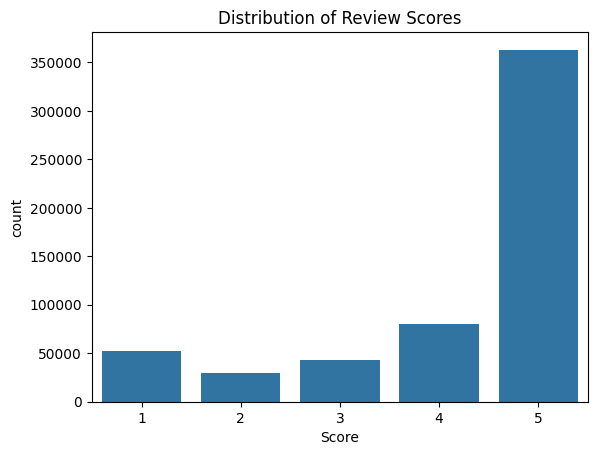

In [ ]:
def map_sentiment(score):
    if score <= 2:
        return 0
    elif score == 3:
        return 1
    else:
        return 2

df['Sentiment'] = df['Score'].apply(map_sentiment)

print("\nDistribution of Review Scores:")
sns.countplot(x='Score', data=df)
plt.title("Distribution of Review Scores")
plt.show()



Sentiment Count:


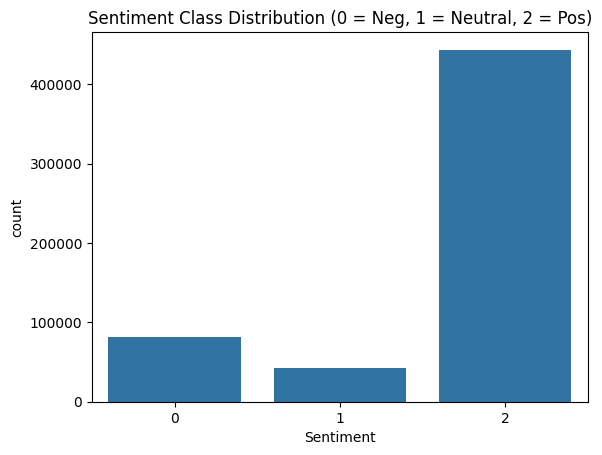

In [ ]:
print("\nSentiment Count:")
sns.countplot(x='Sentiment', data=df)
plt.title("Sentiment Class Distribution (0 = Neg, 1 = Neutral, 2 = Pos)")
plt.show()

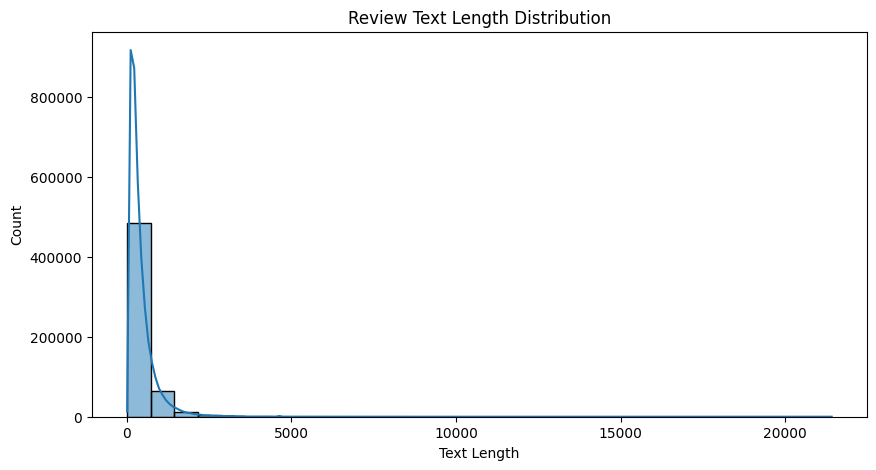

In [ ]:
df['TextLength'] = df['Text'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(df['TextLength'], bins=30, kde=True)
plt.title("Review Text Length Distribution")
plt.xlabel("Text Length")
plt.show()



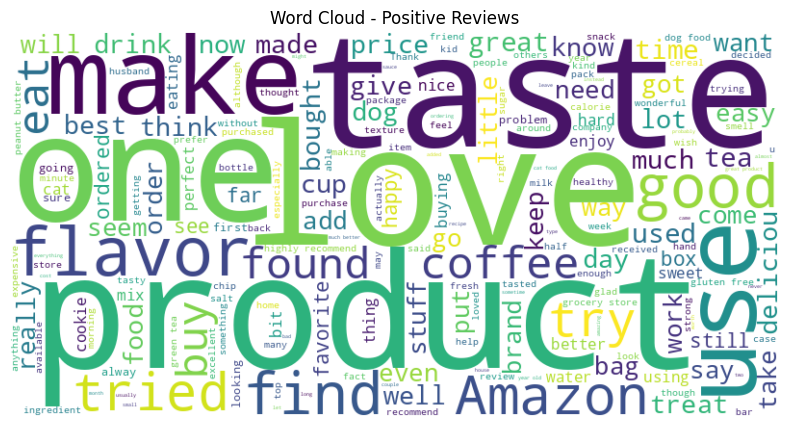

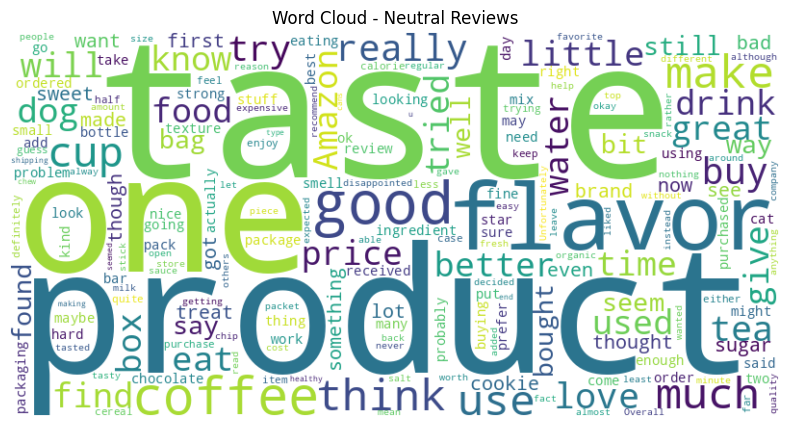

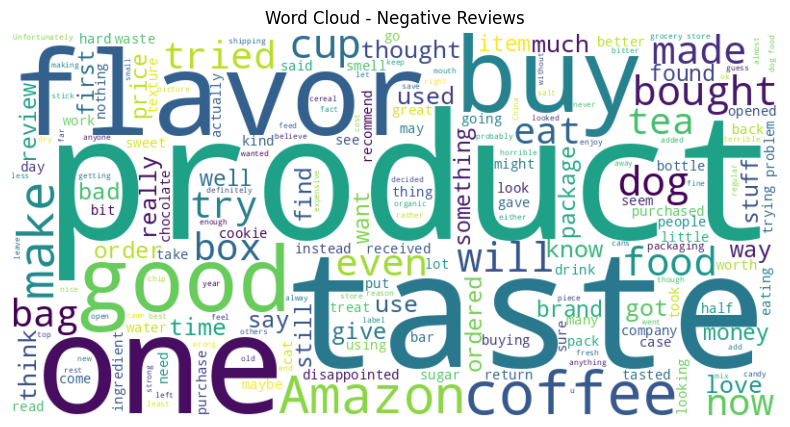

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(sentiment):
    text = " ".join(
        df[df['Sentiment'] == sentiment]['Text']
        .str.replace(r'\bbr\b', '', regex=True)
        .str.replace(r'<.*?>', '', regex=True)
    )
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    sentiment_label = {0: "Negative", 1: "Neutral", 2: "Positive"}
    plt.title(f"Word Cloud - {sentiment_label[sentiment].capitalize()} Reviews")
    plt.show()

show_wordcloud(2) # Positive reviews have sentiment label 2
show_wordcloud(1) # Neutral reviews have sentiment label 1
show_wordcloud(0) # Negative reviews have sentiment label 0

In [ ]:
def preprocess_text(text):
    text = str(text).lower()
    text = contractions.fix(text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def next_word_negation(text):
    words = text.split()
    negation_words = {"not", "no", "never", "n't"}
    new_words = []
    negate = False
    for word in words:
        if word in negation_words:
            negate = True
        elif negate:
            new_words.append("not_" + word)
            negate = False
        else:
            new_words.append(word)
    return " ".join(new_words)



In [ ]:
df['Cleaned_Text'] = df['Text'].apply(preprocess_text).apply(next_word_negation)

max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Cleaned_Text'])
sequences = tokenizer.texts_to_sequences(df['Cleaned_Text'])



In [ ]:
X = pad_sequences(sequences, maxlen=max_len)
y = to_categorical(df['Sentiment'], num_classes=3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=4, batch_size=128, validation_split=0.1)

y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Epoch 1/4
3198/3198 ━━━━━━━━━━━━━━━━━━━━ 112s 33ms/step - accuracy: 0.8395 - loss: 0.4550 - val_accuracy: 0.8927 - val_loss: 0.2837
Epoch 2/4
3198/3198 ━━━━━━━━━━━━━━━━━━━━ 134s 31ms/step - accuracy: 0.9004 - loss: 0.2675 - val_accuracy: 0.9046 - val_loss: 0.2597
Epoch 3/4
3198/3198 ━━━━━━━━━━━━━━━━━━━━ 141s 31ms/step - accuracy: 0.9196 - loss: 0.2218 - val_accuracy: 0.9093 - val_loss: 0.2513
Epoch 4/4
3198/3198 ━━━━━━━━━━━━━━━━━━━━ 101s 31ms/step - accuracy: 0.9331 - loss: 0.1883 - val_accuracy: 0.9131 - val_loss: 0.2469
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     16181
           1       0.59      0.50      0.54      8485
           2       0.95      0.97      0.96     89025

    accuracy                           0.91    113691
   macro avg       0.79      0.76      0.77    113691
weighted avg       0.91      0.91      0.91    113691



Confusion Matrix:
[[0.8065 0.0842 0.1093]
 [0.1938 0.5025 0.3037]
 [0.0118 0.0179 0.9702]]


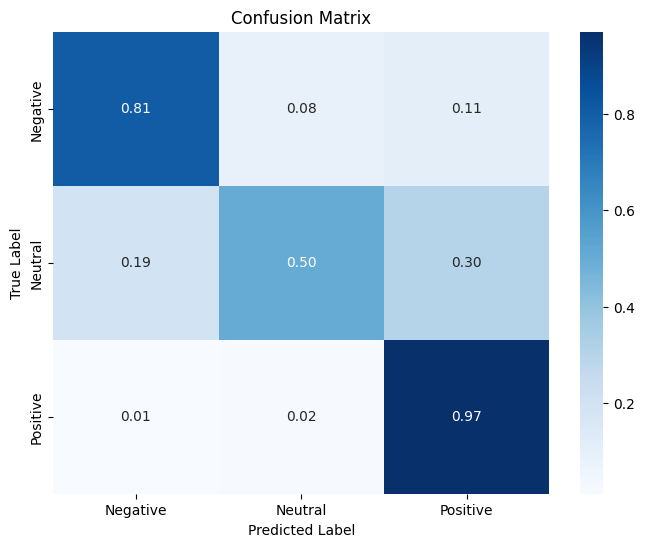

In [ ]:
cm = confusion_matrix(y_true, y_pred)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


print("Confusion Matrix:")
print(np.round(cm_normalized, 4))


plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()